# Content
- [Data Preprocessing](#d1)
- [Features Construction](#d2)
- [Explore the correlation between features](#d3)
- [Prediction stock returns with Lasso Regression](#d4)
    - [Features Construction](#d5)
    - [Lasso CV](#d7)
- [Alpha Analysis](#d6)

In [79]:
import pandas as pd
import numpy as np
from scipy.stats import rankdata
from talib import RSI, BBANDS, MACD, ATR, MOM, CMO

import warnings
warnings.filterwarnings('ignore')

<a id='d1'></a>
# Data Preprocessing

In [2]:
data = pd.read_csv('./data.csv')
data.head()
data.set_index(pd.to_datetime(data.date), inplace=True)
df_last = pd.pivot_table(data, values='last', index=data.index, columns='ticker')
df_volume = pd.pivot_table(data, values='volume', index=data.index, columns='ticker')

In [3]:
# Nan Value 
x = np.isnan(df_volume).sum()
nan_vol_ticker = x[x>0].index
print('In Volume Num of tickers with Nan Value:', len(x[x>0]))
x = np.isnan(df_last).sum()
nan_last_ticker = x[x>0].index
print('In Volume Num of tickers with Nan Value:', len(x[x>0]))

In Volume Num of tickers with Nan Value: 46
In Volume Num of tickers with Nan Value: 46


In [4]:
# check
nan_last_ticker == nan_vol_ticker

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

Because we need to calculate returns so we cannot use the last ticker with Nan values

In [5]:
# drop tickers with Nan values
df_last.drop(columns=nan_last_ticker, inplace=True)
df_volume.drop(columns=nan_vol_ticker, inplace=True)
df_ret = df_last.pct_change()

In [6]:
df_ret.shape

(2005, 202)

After the data processing, we can see that the data.csv consists 2005 days and 202 stocks.

So I want to construct cross-section features and then make the trading strategies 

My plan is:
1. Single alpha backtesting analysis
2. Construct alphas based on `data.csv`
3. Use these alphas to predict returns via some methods such as LR, Lasso, Ridge as well as using cross validation
4. Alpha analysis

<a id='d2'></a>
# Features Construction

In [15]:
def correlation(x, y, window=10):
    return x.rolling(window).corr(y)

def ts_rank(df, window=10):
    return df.rolling(window).apply(rolling_rank)

def ts_max(df, window=10):
    return df.rolling(window).max()

def rolling_rank(na):
    return rankdata(na)[-1]

def ts_sum(df, window=10):
    return df.rolling(window).sum()

def rank(df):
    return df.rank(axis=1, pct=True)

def delta(df, period=1):
    return df.diff(period)

# alpha processing on cross-section 
def mad(factor):
    median = np.nanmedian(factor, axis=0, keepdims=True)
    mad = np.nanmedian(abs(factor - median), axis=0, keepdims=True)
    high = median + (3 * 1.4826 * mad)
    low = median - (3 * 1.4826 * mad)
    factor = np.where(factor > high, high, factor)
    factor = np.where(factor < low, low, factor)
    return factor

def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

def compute_cmo(close):
    cmo = CMO(close)
    return (cmo - np.mean(cmo))/np.std(cmo)

def compute_bb(close):
    high, mid, low = BBANDS(close, timeperiod=20)
    return pd.DataFrame({'bb_high': high, 'bb_low': low}, index=close.index)

def standardize_series(se):
    # standarlization
    se_std = se.std(axis=0, keepdims=True) 
    se_mean = se.mean(axis=0, keepdims=True)
    return (se - se_mean) / (se_std + 1e-12)

def features_process(se):
    return standardize_series(mad(se))
    
class Features(object):
    def __init__(self, df_volume, df_last):
        self.prices = df_last.stack().to_frame().rename(columns={0:'close'})
        self.prices['volume'] = df_volume.stack().rename('volume')
        self.close = df_last
        self.volume = df_volume
        self.returns = df_last.pct_change()
        
    def prices():
        return self.prices
    
    def alpha1(self):
        # Volument-price divergence is a common phenomenon. 
        # When the stock price rises, the trading volume falls or
        # when the stock price falls, the trading volume rises, 
        # which means that the more full the turnover is, 
        # the greater the probability of the stock price rising later
        df = correlation(ts_rank(self.volume, 5), ts_rank(self.close, 5), 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        alpha = -1 * ts_max(df, 3)
        self.prices['price_vol_corr_1'] = alpha.stack()
        
    def alpha2(self):
        df = correlation(rank(self.close), rank(self.volume), 3)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        alpha = -1 * ts_sum(rank(df), 3)
        self.prices['price_vol_corr_2'] = alpha.stack()
    
    def alpha3(self):
        rsi = self.prices.groupby(level='ticker').close.apply(RSI)
        self.prices['rsi'] = rsi
    
    def alpha4(self):
        self.prices = (self.prices.join(self.prices.groupby(level='ticker').close.apply(compute_bb)))
        self.prices['bb_high'] = self.prices.bb_high.sub(self.prices.close).div(self.prices.bb_high).apply(np.log1p)
        self.prices['bb_low'] = self.prices.close.sub(self.prices.bb_low).div(self.prices.close).apply(np.log1p)
        
    def alpha5(self):
        self.prices['macd'] = self.prices.groupby('ticker', group_keys=False).close.apply(compute_macd)
    
    def alpha6(self):
        df = -1 * correlation(self.close, self.volume, 10)
        alpha =  df.replace([-np.inf, np.inf], 0).fillna(value=0)
        self.prices['price_vol_corr_3'] = alpha.stack()
        
    def alpha7(self):
        df = correlation(self.close, self.volume, 10)
        df = df.replace([-np.inf, np.inf], 0).fillna(value=0)
        alpha = -1 * rank(delta(self.returns, 3)) * df
        self.prices['price_vol_corr_4'] = alpha.stack()
    
    def alpha8(self):
        self.prices['cmo'] = (self.prices.groupby('ticker', group_keys=False).close.apply(compute_cmo))
        
    def compute_Lagged_Returns(self):
        # Momentum is very obvious in almost all assets
        # I construct different kinds of momentum factors
        lags = [1, 5, 10, 21, 42, 63]
        q = 0.0001
        for lag in lags:
            self.prices[f'return_{lag}d'] = (self.prices.groupby(level='ticker').close.pct_change(lag).
                                             pipe(lambda x: x.clip(lower=x.quantile(q),upper=x.quantile(1 - q)))
                                             .add(1).pow(1 / lag).sub(1))
    
    def Shift_lagged_returns(self):
        for t in [1, 2, 3, 4, 5]:
            for lag in [1, 5, 10, 21]:
                self.prices[f'return_{lag}d_lag{t}'] = (self.prices.groupby(level='ticker')[f'return_{lag}d'].shift(t * lag))
    
    def compute_forward_returns(self):
        # construct predicting target for lasso regression
        for t in [1, 5, 10, 21]:
            self.prices[f'target_{t}d'] = self.prices.groupby(level='ticker')[f'return_{t}d'].shift(-t)
    
    def dummy(self):
        # construct year and month into dummy features
        self.prices['month'] = self.prices.index.get_level_values('date').month
        self.prices = pd.get_dummies(self.prices, columns=['month'], prefix=['month'],
                                     prefix_sep=['_'], drop_first=True)
        

In [16]:
features = Features(df_volume, df_last)
features.alpha1()
features.alpha2()
features.alpha3()
features.alpha4()
features.alpha5()
features.alpha6()
features.alpha7()
features.alpha8()
features.compute_Lagged_Returns()
features.Shift_lagged_returns()
features.compute_forward_returns()
features.dummy()

In [17]:
features.prices.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 405010 entries, (Timestamp('2013-01-04 00:00:00'), '1332 JT') to (Timestamp('2021-03-19 00:00:00'), '9984 JT')
Data columns (total 52 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   close             405010 non-null  float64
 1   volume            405010 non-null  float64
 2   price_vol_corr_1  404606 non-null  float64
 3   price_vol_corr_2  404606 non-null  float64
 4   rsi               402182 non-null  float64
 5   bb_high           401172 non-null  float64
 6   bb_low            401172 non-null  float64
 7   macd              398344 non-null  float64
 8   price_vol_corr_3  405010 non-null  float64
 9   price_vol_corr_4  404202 non-null  float64
 10  cmo               402182 non-null  float64
 11  return_1d         404808 non-null  float64
 12  return_5d         404000 non-null  float64
 13  return_10d        402990 non-null  float64
 14  return_21d        400768 non-null

<a id='d3'></a>
# Explore the correlation between features

In [18]:
data = features.prices
y = data.filter(like='target')
X = data.drop(y.columns, axis=1)
X = X.drop(['volume', 'close'], axis=1)

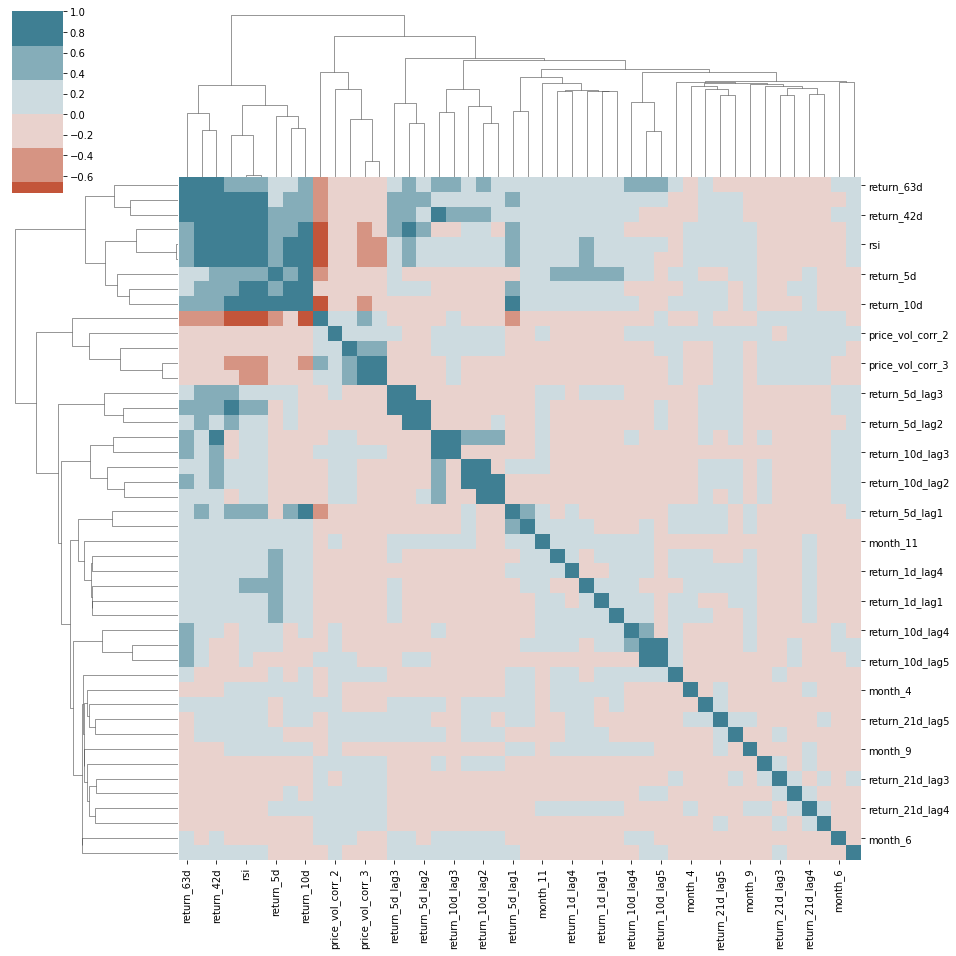

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0);
plt.gcf().set_size_inches((14, 14))

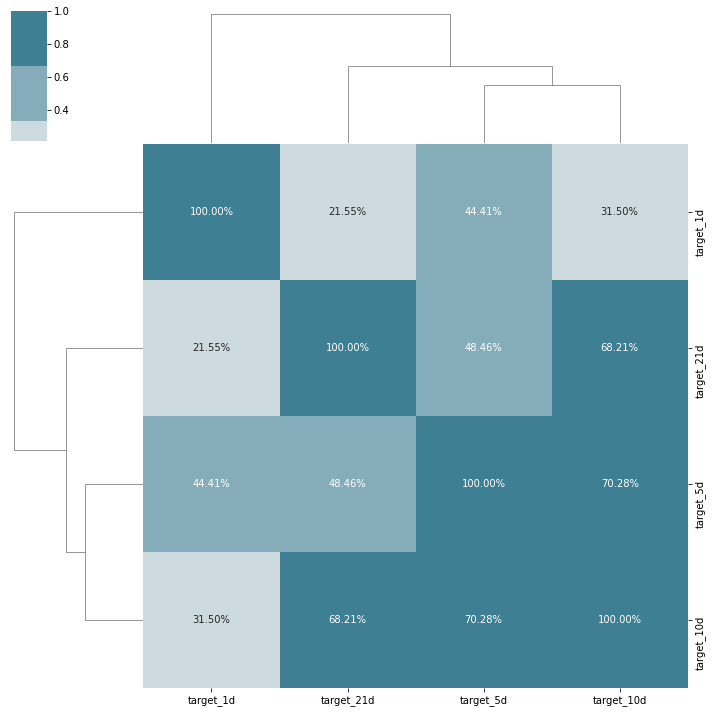

In [20]:
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0, annot=True, fmt='.2%');

In [21]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1 != corr_mat.var2].sort_values(by='corr', ascending=False)
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
370,cmo,rsi,0.993449
100,rsi,cmo,0.993449
283,price_vol_corr_3,price_vol_corr_4,0.859307
328,price_vol_corr_4,price_vol_corr_3,0.859307
557,return_21d,macd,0.836400
509,return_10d,bb_high,-0.757048
146,bb_high,cmo,-0.758412
371,cmo,bb_high,-0.758412
140,bb_high,rsi,-0.767081
95,rsi,bb_high,-0.767081


So we can see that these exists high correlation between the features that I constructed, so I would like to use Lasso Regression to predict returns as well as feature shrinking.

<a id='d4'></a>
# Prediction stock returns with Lasso Regression

<a id='d7'></a>
## Lasso CV

In [96]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [23]:
sns.set_style('darkgrid')
idx = pd.IndexSlice
YEAR = 252

In [24]:
# Custom MultipleTimeSeriesCV
class MultipleTimeSeriesCV:
    def __init__(self, n_splits, train_period_length, test_period_length, lookahead=None, shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])
        dates = X.reset_index()[['date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.date > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [25]:
# Verify that it works
# Use the past 3 months data to predict the next ten days
train_period_length = 63 
test_period_length = 10
n_splits = int(4*YEAR/(test_period_length))
lookahead =1 
cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length, 
                          lookahead=lookahead, train_period_length=train_period_length)

In [26]:
i = 0
for train_idx, test_idx in cv.split(X=data):
    train = data.iloc[train_idx]
    train_dates = train.index.get_level_values('date')
    test = data.iloc[test_idx]
    test_dates = test.index.get_level_values('date')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n == len(df.drop_duplicates())
    print(train.groupby(level='ticker').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='ticker').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i > 10:
        break

63 2020-12-02 2021-03-05 10 2021-03-08 2021-03-19
63 2020-11-17 2021-02-18 10 2021-02-19 2021-03-05
63 2020-11-02 2021-02-03 10 2021-02-04 2021-02-18
63 2020-10-19 2021-01-20 10 2021-01-21 2021-02-03
63 2020-10-05 2021-01-05 10 2021-01-06 2021-01-20
63 2020-09-16 2020-12-18 10 2020-12-21 2021-01-05
63 2020-09-02 2020-12-04 10 2020-12-07 2020-12-18
63 2020-08-19 2020-11-19 10 2020-11-20 2020-12-04
63 2020-08-04 2020-11-05 10 2020-11-06 2020-11-19
63 2020-07-17 2020-10-21 10 2020-10-22 2020-11-05
63 2020-07-03 2020-10-07 10 2020-10-08 2020-10-21


In [86]:
#Define cross-validation parameters
lasso_alphas = np.logspace(-7, -4, 4)

n_splits = int(3*YEAR/test_period_length)
train_period_length = 63
test_period_length = 10
lookahead = 1
target = f'target_{lookahead}d'

cv = MultipleTimeSeriesCV(n_splits=n_splits, test_period_length=test_period_length, 
                          lookahead=lookahead, train_period_length=train_period_length)

In [28]:
np.isnan(X).sum() / X.shape[0]
print(X.shape)

(405010, 46)


In [29]:
# X.groupby(level='date').apply(lambda x: x.fillna(x.mean(skipna=True)))
X.dropna(inplace=True)
print(X.shape)

(379558, 46)


In [87]:
%%time
lasso_coeffs, lasso_scores, lasso_predictions = {}, [], []
for alpha in lasso_alphas:
    print(alpha, end=' ', flush=True)
    model = Lasso(alpha=alpha, fit_intercept=False, random_state=42, tol=1e-3, max_iter=200, warm_start=True, selection='random')
    pipe = Pipeline([('scaler', StandardScaler()), ('model', model)])
    coeffs = []
    for i, (train_idx, test_idx) in enumerate(cv.split(X), 1):
        t = time()
        X_train, y_train, = X.iloc[train_idx], y[target].iloc[train_idx]
        X_test, y_test = X.iloc[test_idx], y[target].iloc[test_idx]
        pipe.fit(X=X_train, y=y_train)
        y_pred = pipe.predict(X_test)
        preds = y_test.to_frame('actuals').assign(predicted=y_pred)
        preds_by_day = preds.groupby(level='date')
        scores = pd.concat([preds_by_day.apply(lambda x: spearmanr(x.predicted,x.actuals)[0] * 100).to_frame('ic'),
                            preds_by_day.apply(lambda x: np.sqrt(mean_squared_error(y_pred=x.predicted, y_true=x.actuals))).to_frame('rmse')],axis=1)
        lasso_scores.append(scores.assign(alpha=alpha))
        lasso_predictions.append(preds.assign(alpha=alpha))
        coeffs.append(pipe.named_steps['model'].coef_)
    lasso_coeffs[alpha] = np.mean(coeffs, axis=0)

1e-07 1e-06 1e-05 0.0001 CPU times: total: 5min 30s
Wall time: 4min 27s


In [88]:
lasso_scores = pd.concat(lasso_scores)
lasso_coeffs = pd.DataFrame(lasso_coeffs, index=X.columns).T
lasso_predictions = pd.concat(lasso_predictions)
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
preds = lasso_predictions[lasso_predictions.alpha==best_alpha]
lasso_r, lasso_p = spearmanr(preds.actuals, preds.predicted)
print(f'Information Coefficient (overall): {lasso_r:.3%} (p-value: {lasso_p:.4%})')

Information Coefficient (overall): 11.221% (p-value: 0.0000%)


In [89]:
lasso_scores.groupby('alpha').ic.agg(['mean', 'median'])

,mean,median
alpha,,
1.000000e-07,14.347701,15.094241
1.000000e-06,14.367212,15.126738
1.000000e-05,14.475653,15.089127
1.000000e-04,15.176549,16.341329


<a id='d5'></a>
## Lasso IC Distribution and Top 10 Features

In [90]:
def plot_ic_distribution(df, ax=None):
    if ax is not None:
        sns.distplot(df.ic, ax=ax)
    else:
        ax = sns.distplot(df.ic)
    mean, median = df.ic.mean(), df.ic.median()
    ax.axvline(0, lw=1, ls='--', c='k')
    ax.text(x=.05, y=.9, s=f'Mean: {mean:8.2f}\nMedian: {median:5.2f}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes)
    ax.set_xlabel('Information Coefficient')
    sns.despine()
    plt.tight_layout()

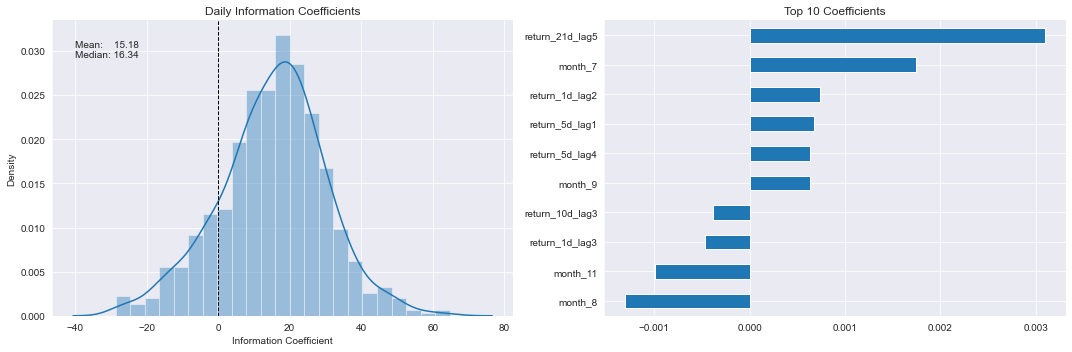

In [91]:
best_alpha = lasso_scores.groupby('alpha').ic.mean().idxmax()
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
plot_ic_distribution(lasso_scores[lasso_scores.alpha==best_alpha], ax=axes[0])
axes[0].set_title('Daily Information Coefficients')

top_coeffs = lasso_coeffs.loc[best_alpha].abs().sort_values(ascending=False).head(10).index
top_coeffs.tolist()
lasso_coeffs.loc[best_alpha, top_coeffs].sort_values().plot.barh(ax=axes[1], title='Top 10 Coefficients')

sns.despine()
fig.tight_layout()

<a id='d6'></a>
# Alpha Analysis

In [92]:
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_summary_tear_sheet
idx = pd.IndexSlice

In [93]:
def get_best_alpha(scores):
    return scores.groupby('alpha').ic.mean().idxmax()

def get_factor(predictions):
    return (predictions.unstack('ticker').dropna(how='all').stack().tz_localize('UTC', level='date').sort_index())    

In [94]:
lasso_scores_reset = lasso_scores.reset_index()
best_lasso_alpha = get_best_alpha(lasso_scores_reset)
lasso_predictions = lasso_predictions[lasso_predictions.alpha==best_lasso_alpha]
lasso_predictions_select = lasso_predictions.drop('alpha', axis=1)
lasso_factor = get_factor(lasso_predictions_select.predicted.swaplevel())
lasso_factor.head()

date                       ticker 
2017-08-14 00:00:00+00:00  1332 JT   -0.002860
                           1605 JT   -0.001718
                           1721 JT   -0.000696
                           1801 JT    0.002762
                           1802 JT   -0.000461
dtype: float64

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.046634,0.015887,-0.006348,0.006258,30750,20.29703
2,-0.022678,0.020698,-0.002411,0.005219,30000,19.80198
3,-0.019572,0.024606,-0.000302,0.005154,30000,19.80198
4,-0.017209,0.029503,0.001811,0.005273,30000,19.80198
5,-0.013780,0.050407,0.005821,0.006422,30750,20.29703


Returns Analysis


,1D,5D,10D,21D
Ann. alpha,1.331,1.285,1.302,1.294
beta,0.019,-0.012,-0.048,-0.072
Mean Period Wise Return Top Quantile (bps),34.607,34.331,34.611,34.830
Mean Period Wise Return Bottom Quantile (bps),-35.210,-33.878,-34.723,-35.133
Mean Period Wise Spread (bps),69.817,68.220,69.348,69.987


Information Analysis


,1D,5D,10D,21D
IC Mean,0.152,0.349,0.512,0.775
IC Std.,0.149,0.150,0.144,0.127
Risk-Adjusted IC,1.015,2.319,3.569,6.120
t-stat(IC),27.809,63.497,97.735,167.595
p-value(IC),0.000,0.000,0.000,0.000
IC Skew,-0.188,-0.430,-0.587,-1.435
IC Kurtosis,0.310,0.377,0.401,3.110


Turnover Analysis


,1D,5D,10D,21D
Quantile 1 Mean Turnover,0.340,0.535,0.634,0.791
Quantile 2 Mean Turnover,0.603,0.725,0.762,0.800
Quantile 3 Mean Turnover,0.638,0.743,0.768,0.787
Quantile 4 Mean Turnover,0.602,0.726,0.765,0.798
Quantile 5 Mean Turnover,0.337,0.527,0.633,0.783


,1D,5D,10D,21D
Mean Factor Rank Autocorrelation,0.767,0.488,0.309,-0.015


<Figure size 432x288 with 0 Axes>

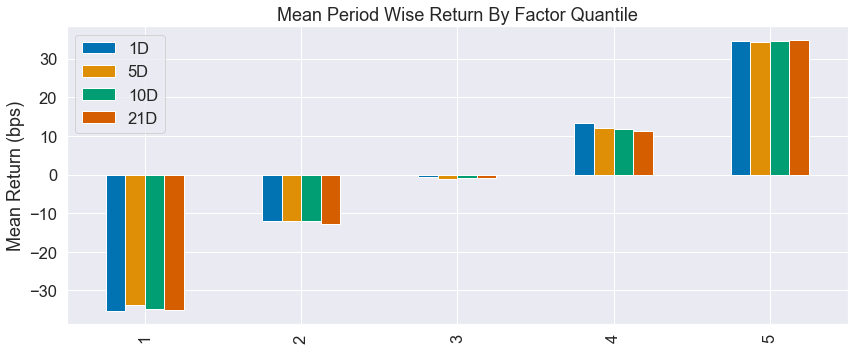

In [95]:
tickers = lasso_factor.index.get_level_values('ticker').unique()
lasso_factor_data = get_clean_factor_and_forward_returns(factor=lasso_factor, prices=df_last.tz_localize('UTC', level='date'), 
                                                         quantiles=5, periods=(1, 5, 10, 21))
create_summary_tear_sheet(lasso_factor_data)

So we can see that the predit result of the lasso regression has good linearity and the layered return rate is very obvious.

We can hold the stocks that ranks in the top based on predicted return by lasso regression.